<a href="https://colab.research.google.com/github/dmandic17/medical-drug-review-analysis/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis

**In this notebook, we experiment with some sentiment analysis methods (on reviews)**

Used: TextBlob (number for sentiment); 
Classification (0,1,2): Multinomial Naive Bayes, Random Forest, XGBoost

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('../data/drugsComTrain_top_conditions.csv')
test = pd.read_csv('../data/drugsComTest_top_conditions.csv')

In [3]:
import warnings
warnings.filterwarnings("ignore")

## TextBlob Sentiment Analysis

In [4]:
from textblob import TextBlob

In [5]:
# testing the lib:
example1 = "This is a wonderful product. I am amazed by it."  # should be positive
example2 = "This is a terrible product. I would not recommend using it." # should be negative
example3 = "Hello." # should be neutral

blob1 = TextBlob(example1)
blob2 = TextBlob(example2)
blob3 = TextBlob(example3)

print(blob1.sentiment)
print(blob2.sentiment)
print(blob3.sentiment)

Sentiment(polarity=1.0, subjectivity=1.0)
Sentiment(polarity=-1.0, subjectivity=1.0)
Sentiment(polarity=0.0, subjectivity=0.0)


Note: Subjectivity is not relevant here, we only care about the sentiment and whether it matches to the rating.

In [6]:
from tqdm import tqdm

reviews = train["review"]

def check_sentiments(reviews, data):
    sentiments = []
    for review in tqdm(reviews):
        blob = TextBlob(review)
        sentiments += [blob.sentiment.polarity]

    data["sentiment"] = sentiments
    
check_sentiments(reviews, train)

100%|█████████████████████████████████████████████████████████████████████| 129376/129376 [00:53<00:00, 2440.36it/s]


In [7]:
train.sample(5)

,Unnamed: 0,uniqueID,drugName,condition,review,rating,date,usefulCount,condition_count,sentiment
87470,109036,106745,Implanon,Birth Control,"""Had mine for a year, did gain half a stone af...",5,29-May-15,2,28788.0,0.148889
35282,44019,112323,Contrave,Obesity,"""I&#039;m not sure I can do this medication. ...",3,28-Jan-15,58,3568.0,-0.125000
120742,150548,163694,Mirtazapine,Depression,"""So far I haven&#039;t seen anyone on here tha...",9,27-Jan-13,81,9069.0,0.216649
88950,110859,106937,Implanon,Birth Control,"""I have had Implanon for over a year and the s...",1,2-Jan-14,28,28788.0,-0.525000
4341,5402,163818,Mirtazapine,Depression,"""This antidepressant has been a blessing in my...",10,12-Sep-09,190,9069.0,0.159722


In [8]:
# Do these sentiments "match" with the rating?

import numpy as np

corr = np.corrcoef(train["rating"], train["sentiment"])
print(corr)

[[1.         0.35828972]
 [0.35828972 1.        ]]


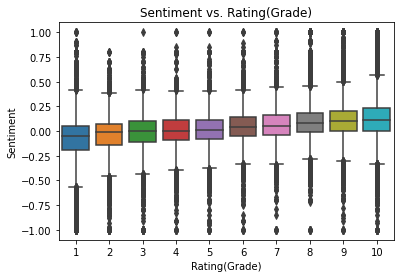

In [9]:
# Plotting the correlations

import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=np.array(train["rating"]),y=np.array(train["sentiment"]))
plt.xlabel("Rating(Grade)")
plt.ylabel("Sentiment")
plt.title("Sentiment vs. Rating(Grade)")
plt.show()

## Possible improvement: review preprocessing

In [10]:
import re
from nltk.corpus import stopwords

s=set(stopwords.words('english'))
s.add("i'm")
s.add('like')
s.add("I've")
s.add('mg')

def filter_the_review(review):
    # remove ""
    review = re.sub('\"', '', review)
    
    # replace &#39; -> this is equivlaent to '
    review = re.sub('&#039;', '\'', review)
    
    # remove .,; &quot
    review = re.sub('[.,;]', '', review)
    review = re.sub('&quot', '', review)
    
    # change to small letters
    review = review.lower()
    
    # remove numbers
    review = re.sub('[0-9]+','', review)
    
    # replace two spaces with one (if they exist somewhere)
    review = re.sub('  ', ' ', review)
    
    # remove the stopwords
    filtered = filter(lambda w: not w in s,review.split())
    
    list_words = list(filtered)
    string_review = " ".join(list_words)
    
    return string_review

filter_all = np.vectorize(filter_the_review)

In [11]:
reviews = filter_all(reviews)
reviews[0]

'son halfway fourth week intuniv became concerned began last week started taking highest dose two days could hardly get bed cranky slept nearly hours drive home school vacation (very unusual him) called doctor monday morning said stick days see school getting morning last two days problem free much agreeable ever less emotional (a good thing) less cranky remembering things overall behavior better tried many different medications far effective'

In [12]:
check_sentiments(reviews, train)

100%|█████████████████████████████████████████████████████████████████████| 129376/129376 [00:31<00:00, 4058.18it/s]


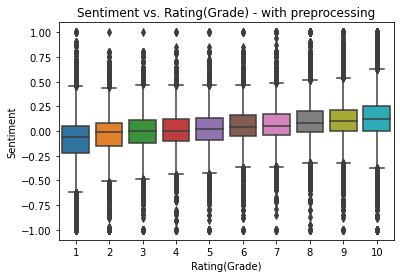

In [13]:
sns.boxplot(x=np.array(train["rating"]),y=np.array(train["sentiment"]))
plt.xlabel("Rating(Grade)")
plt.ylabel("Sentiment")
plt.title("Sentiment vs. Rating(Grade) - with preprocessing")
plt.show()

In [14]:
corr = np.corrcoef(train["rating"], train["sentiment"])
print(corr)

[[1.         0.34749598]
 [0.34749598 1.        ]]


Note: Even a bit less correlation - maybe it is because of removing 'not' (it is included in stopwords)

## Reviews to vectors

In [15]:
# Calculate the sentiment and filter the reviews as a preprocessing step

train['sentiment'] = train["rating"].apply(lambda x: 2 if x > 7 else (1 if ((x>4)&(x<=7)) else 0))
test['sentiment'] = test["rating"].apply(lambda x: 2 if x > 7 else (1 if ((x>4)&(x<=7)) else 0))
train['review_filtered'] = reviews # filtered
test['review_filtered'] = filter_all(test['review'])
solution = test['sentiment']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# Vectorize the reviews to get numerical data

vectorizer = TfidfVectorizer()

frames = [train, test]
all_data = pd.concat(frames)

reviews_corpus = vectorizer.fit_transform(all_data['review'])
reviews_corpus.shape

(172615, 45434)

In [18]:
# Fetch sentiment (this is Y)

sentiment = all_data['sentiment']
sentiment.shape

(172615,)

In [19]:
# Split the data:

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(reviews_corpus,sentiment,test_size=0.33,random_state=42)
print('Train data shape ',X_train.shape,Y_train.shape)
print('Test data shape ',X_test.shape,Y_test.shape)

Train data shape  (115652, 45434) (115652,)
Test data shape  (56963, 45434) (56963,)


## Multinomial Naive Bayes

Accuracy: 0.6507381984797149
Confusion Matrix


<AxesSubplot:>

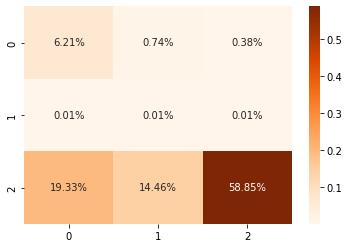

In [20]:
# Fit the model and predicct the output
 
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB 

clf = MultinomialNB().fit(X_train, Y_train) #fit the training data

pred = clf.predict(X_test) #predict the sentiment for test data

print("Accuracy: %s" % str(clf.score(X_test, Y_test)))
print("Confusion Matrix") 
cf_matrix = confusion_matrix(pred, Y_test)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Oranges')

## Random Forest

Accuracy: 0.8510085494092656
Confusion Matrix


<AxesSubplot:>

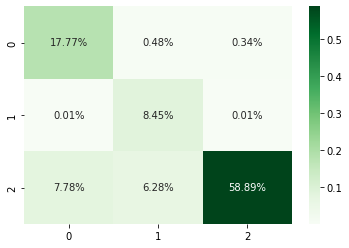

In [21]:
# Fit the model and predicct the output

from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier().fit(X_train, Y_train)

pred = clf.predict(X_test)

print("Accuracy: %s" % str(clf.score(X_test, Y_test)))
print("Confusion Matrix")
cf_matrix = confusion_matrix(pred, Y_test)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Greens')

## XGBoost

[21:09:49] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:09:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7106191738496919
Confusion Matrix


<AxesSubplot:>

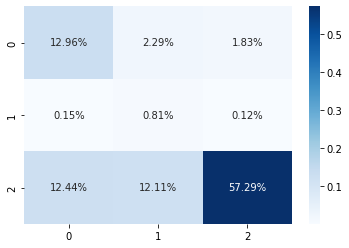

In [22]:
# Fit the model and predicct the output

from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimator = 10000,
                    learning_rate=0.10,
                    num_leaves=30)

model_xgb = xgb_clf.fit(X_train, Y_train)

pred = model_xgb.predict(X_test)

print("Accuracy: %s" % str(model_xgb.score(X_test, Y_test)))
print("Confusion Matrix") 
cf_matrix = confusion_matrix(pred, Y_test)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [23]:
print("Accuracy: %s" % str(model_xgb.score(X_test, Y_test)))

Accuracy: 0.7106191738496919
